**Text Clustering and
Topic Modeling**

In [28]:
#to view the data loaded from huggingface in a proper view format spreadsheet type sheet, we convert it to pd.datafram3, or otherwise just print(dataset[0])



# import torch

# # Set device once at the top
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# print(f"Using {device}")

# # When loading models
# model.to(device)

# # When passing data
# data = data.to(device)

In [29]:
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer

# Set device to MPS (Apple GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

# Load dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
abstract = dataset["Abstracts"]
titles= dataset["Titles"]
# Load model and move it to GPU
embedding_model = SentenceTransformer("thenlper/gte-small")
embedding_model.to(device)  # This moves the model to MPS

# Encode using GPU
embeddings = embedding_model.encode(
    list(abstract),
    show_progress_bar=True,
    device=device.type  # <This is key
)


Using device: mps


/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Batches: 100%|██████████| 1405/1405 [09:04<00:00,  2.58it/s]


In [30]:
dataset

Dataset({
    features: ['Titles', 'Abstracts', 'Years', 'Categories'],
    num_rows: 44949
})

In [31]:
embeddings.shape

(44949, 384)

In [32]:
from umap import UMAP
umap_model=UMAP(
    n_components=5,min_dist=0.0,metric="cosine", random_state=42
)
reduce_embeddings=umap_model.fit_transform(embeddings)

/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [33]:
from hdbscan import HDBSCAN
hdbscan_model=HDBSCAN(min_cluster_size=50, metric='euclidean',cluster_selection_method="eom").fit(reduce_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
TOKENIZERS_PARALLELISM=(true | false)
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable 	- Avoid using `tokenizers` before the fork if possible
	

In [34]:
clusters=hdbscan_model.labels_

In [35]:
len(set(clusters))

160

In [36]:
import numpy as np
cluster=22
for index in np.where(clusters==cluster)[0][:3]:
    print(abstract[int(index)][:300]+ "...\n")

  Since the late 1990s when speech companies began providing their
customer-service software in the market, people have gotten used to speaking to
machines. As people interact more often with voice and gesture controlled
machines, they expect the machines to recognize different emotions, and
underst...

  Perception and expression of emotion are key factors to the success of
dialogue systems or conversational agents. However, this problem has not been
studied in large-scale conversation generation so far. In this paper, we
propose Emotional Chatting Machine (ECM) that can generate appropriate
respo...

  Empathy, as defined in behavioral sciences, expresses the ability of human
beings to recognize, understand and react to emotions, attitudes and beliefs of
others. The lack of an operational definition of empathy makes it difficult to
measure it. In this paper, we address two related problems in au...



In [37]:
import pandas as pd
reduce_embeddings=UMAP(n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

df=pd.DataFrame(reduce_embeddings,columns=['x','y'])
df["title"]= titles
df["cluster"]=[str(c) for c in clusters]

clusters_df= df.loc[df.cluster != "-1", :]
outliers_df=df.loc[df.cluster == "-1", :]

/Users/abhimanyu/Desktop/geospacy/venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(-8.84580488204956, 11.425997447967529, -8.40596239566803, 11.39526550769806)

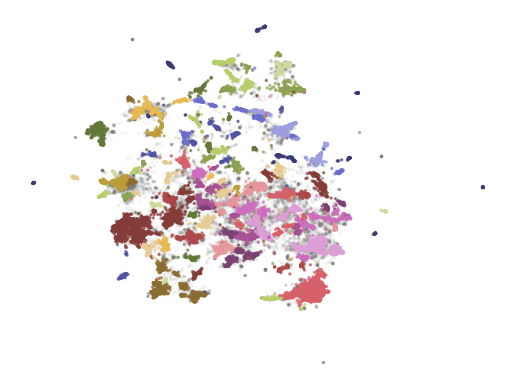

In [43]:
import matplotlib.pyplot as plt

plt.scatter(outliers_df.x, outliers_df.y,alpha=0.05,s=2, c="grey")
plt.scatter(
    clusters_df.x, clusters_df.y,c=clusters_df.cluster.astype(int),alpha=0.6, s=2,cmap="tab20b"

)
plt.axis("off")

visually appealing maybe but definitely not of much use so we move onto topic modelling

In [45]:
from bertopic import BERTopic

topic_model=BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
).fit(abstract,embeddings)

AttributeError: module 'openai' has no attribute 'OpenAI'